# Hitter Performance Against Starting Pitchers and Relief Pitchers

## Fetch Data from Fangraphs' Splits Leaderboards and Export to CSV

In [1]:
import requests
import json
import pandas as pd
import time

def get_fangraphs_splits(stat_type = 'player', group_by = 'season', split_array: list[int] = [], csv_name = 'file'):
    json_data = {
        'strPlayerId': 'all',
        'strSplitArr': split_array,
        'strGroup': group_by,
        'strPosition': 'B',
        'strType': '2',
        'strStartDate': '2000-03-01',
        'strEndDate': '2023-11-01',
        'strSplitTeams': False,
        'dctFilters': [
            {
                'stat': 'PA',
                'low': '0',
                'high': -99,
                'comp': 'gt',
                'auto': False,
                'pending': True,
                'label': 'PA ≥ 0',
                'value': 0
            }
        ],
        'strStatType': stat_type,
        'strAutoPt': 'false',
        'arrPlayerId': [],
        'strSplitArrPitch': [],
        'arrWxTemperature': None,
        'arrWxPressure': None,
        'arrWxAirDensity': None,
        'arrWxElevation': None,
        'arrWxWindSpeed': None
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest'
    }
    resp_json = json.loads(requests.post('https://www.fangraphs.com/api/leaders/splits/splits-leaders', json = json_data, headers = headers).text)
    df = pd.DataFrame(resp_json['data'])
    output_path = f'~/Downloads/{csv_name}.csv'
    df.to_csv(output_path, index = False)
    print(f'Successfully exported to {output_path}')
    return df

def data_quality_check(df):
    test_df = df.loc[~df['PA'].eq(df['PA vs. SP'] + df['PA vs. RP'])]
    assert len(test_df.index) == 0, display(test_df)

In [2]:
for kwargs in [
    # {'csv_name': 'Player Seasons'},
    # {'split_array': [42], 'csv_name': 'Player Seasons vs SP'},
    # {'split_array': [43], 'csv_name': 'Player Seasons vs RP'},
    # {'group_by': 'career', 'split_array': [], 'csv_name': 'Player Careers'},
    # {'group_by': 'career', 'split_array': [42], 'csv_name': 'Player Careers vs SP'},
    # {'group_by': 'career', 'split_array': [43], 'csv_name': 'Player Careers vs RP'},
    # {'stat_type': 'mlb', 'csv_name': 'League Seasons'},
    # {'stat_type': 'mlb', 'split_array': [42], 'csv_name': 'League Seasons vs SP'},
    # {'stat_type': 'mlb', 'split_array': [43], 'csv_name': 'League Seasons vs RP'}
]:
    get_fangraphs_splits(**kwargs)
    time.sleep(5)

## Read CSV Files

In [3]:
dtypes = {
    # 'Season': int, # Can be int like 2023 or str like "Total"
    'League': str,
    'playerName': str,
    'playerId': int,
    'TeamNameAbb': str,
    'PA': int,
    'AVG': float,
    'BB%': float,
    'K%': float,
    'BB/K': float,
    'OBP': float,
    'SLG': float,
    'OPS': float,
    'ISO': float,
    'BABIP': float,
    'wRC': float,
    'wRAA': float,
    'wOBA': float,
    'wRC+': float
}

def read_csv(file_path: str, usecols: list[str] = []):
    df = pd.DataFrame()
    if len(usecols) > 0:
        df = pd.read_csv(file_path, usecols = usecols)
    else:
        df = pd.read_csv(file_path)
    df = df.astype({k: v for k, v in dtypes.items() if k in df.columns})
    return df

In [4]:
player_seasons_df = read_csv('~/Downloads/Player Seasons.csv', usecols = ['Season', 'playerId', 'playerName', 'PA', 'wRC+']) \
    .merge(read_csv('~/Downloads/Player Seasons vs SP.csv', usecols = ['Season', 'playerId', 'PA', 'wRC+']), how = 'left', on = ['Season', 'playerId'], suffixes = ('', ' vs. SP')) \
    .merge(read_csv('~/Downloads/Player Seasons vs RP.csv', usecols = ['Season', 'playerId', 'PA', 'wRC+']), how = 'left', on = ['Season', 'playerId'], suffixes = ('', ' vs. RP')) \
    .fillna(0)
data_quality_check(player_seasons_df)
player_seasons_df

,Season,playerName,playerId,PA,wRC+,PA vs. SP,wRC+ vs. SP,PA vs. RP,wRC+ vs. RP
0,2002,Alfredo Amezaga,1,13,239.248850,9.0,172.585796,4.0,389.240722
1,2002,Garret Anderson,2,678,123.430501,471.0,142.679444,207.0,78.484217
2,2002,Kevin Appier,3,4,-100.000000,4.0,-100.000000,0.0,0.000000
3,2002,David Eckstein,10,702,105.265604,499.0,97.303663,203.0,124.830374
4,2002,Darin Erstad,11,663,84.488353,472.0,73.426662,191.0,112.113003
...,...,...,...,...,...,...,...,...,...
20255,2023,Heston Kjerstad,31166,33,103.714008,18.0,48.095453,15.0,175.223579
20256,2023,Zach Neto,31347,329,88.614987,188.0,66.020826,141.0,118.955718
20257,2023,Wade Meckler,31490,64,71.790275,37.0,54.632008,27.0,95.303456
20258,2023,Masataka Yoshida,31837,580,109.494756,336.0,98.553132,244.0,124.561910


In [5]:
# player_career_df = read_csv('~/Downloads/Player Careers.csv', usecols = ['playerId', 'playerName', 'PA', 'wRC+']) \
#     .merge(read_csv('~/Downloads/Player Careers vs SP.csv', usecols = ['playerId', 'PA', 'wRC+']), how = 'left', on = 'playerId', suffixes = ('', ' vs. SP')) \
#     .merge(read_csv('~/Downloads/Player Careers vs RP.csv', usecols = ['playerId', 'PA', 'wRC+']), how = 'left', on = 'playerId', suffixes = ('', ' vs. RP')) \
#     .fillna(0)
player_career_df = read_csv('~/Downloads/Player Careers vs SP.csv', usecols = ['playerId', 'PA', 'wRC+']) \
    .merge(read_csv('~/Downloads/Player Careers vs RP.csv', usecols = ['playerId', 'PA', 'wRC+']), how = 'left', on = 'playerId', suffixes = (' vs. SP', ' vs. RP')) \
    .fillna(0)
# data_quality_check(player_career_df)
player_career_df

,playerId,PA vs. SP,wRC+ vs. SP,PA vs. RP,wRC+ vs. RP
0,1,917,65.317634,653.0,70.399163
1,2,3246,107.058744,1511.0,91.072106
2,3,9,-100.000000,0.0,0.000000
3,4,20,49.895921,19.0,9.609931
4,6,294,82.968614,133.0,84.422970
...,...,...,...,...,...
4510,31166,18,48.095453,15.0,175.223579
4511,31347,188,66.020826,141.0,118.955718
4512,31490,37,54.632008,27.0,95.303456
4513,31837,336,98.553132,244.0,124.561910


In [6]:
league_seasons_df = read_csv('~/Downloads/League Seasons.csv', usecols = ['Season', 'PA', 'wRC+']) \
    .merge(read_csv('~/Downloads/League Seasons vs SP.csv', usecols = ['Season', 'PA', 'wRC+']), how = 'left', on = 'Season', suffixes = ('', ' vs. SP')) \
    .merge(read_csv('~/Downloads/League Seasons vs RP.csv', usecols = ['Season', 'PA', 'wRC+']), how = 'left', on = 'Season', suffixes = ('', ' vs. RP'))
data_quality_check(league_seasons_df)
league_seasons_df

,Season,PA,wRC+,PA vs. SP,wRC+ vs. SP,PA vs. RP,wRC+ vs. RP
0,2002,186615,96.356881,123795,98.996987,62820,91.204660
1,2003,187449,96.328841,123603,98.838177,63846,91.484567
2,2004,188539,96.242679,123439,98.985406,65100,91.054320
3,2005,186292,96.480457,125021,98.230633,61271,92.948478
4,2006,188071,96.247121,122956,99.272178,65115,90.552311
5,2007,188623,96.583133,122237,100.592958,66386,89.238751
6,2008,187631,96.392142,121818,99.129871,65813,91.302355
7,2009,187079,96.280655,121839,99.254188,65240,90.750570
8,2010,185553,96.242432,124129,98.006228,61424,92.707727
9,2011,185245,96.496160,124544,99.525789,60701,90.286825


## Introduction

https://library.fangraphs.com/offense/wrc/

"While wOBA is a huge step forward from stats like batting average and slugging percentage, it doesn’t credit hitters who play in difficult parks or deduct points for hitters who play in smaller ones. wRC+ brings all the virtues of wOBA plus two added benefits; park and league adjustments."

The park factor helps to level the playing field so that a Rockies player (hitter-friendly home ballpark) can be usefully compared to a Mariners player (pitcher-friendly home ballpark).<br>
The league adjustment helps when players across different seasons or even generations can be compared despite that the offensive environments in which they played may differ greatly.

| Ratings       | wRC+ |
| ------------- | ---- |
| Excellent     | 160  |
| Great         | 140  |
| Above Average | 115  |
| Average       | 100  |
| Below Average	| 80   |
| Poor          | 75   |
| Awful         | 60   |

## Initial Exploration

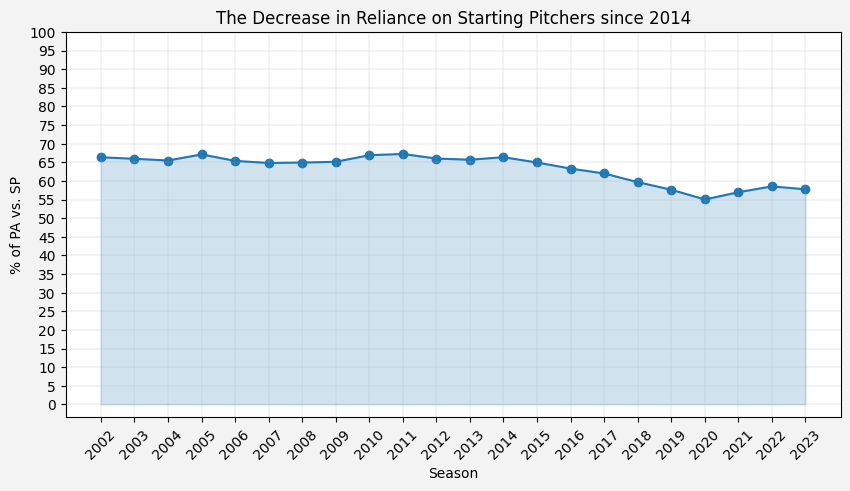

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5), facecolor = '#f3f3f3')
plt.plot(league_seasons_df.Season, 100 * league_seasons_df['PA vs. SP'] / league_seasons_df.PA)
plt.scatter(league_seasons_df.Season, 100 * league_seasons_df['PA vs. SP'] / league_seasons_df.PA)
plt.fill_between(league_seasons_df.Season, 100 * league_seasons_df['PA vs. SP'] / league_seasons_df.PA, 0, color = 'C0', alpha = 0.2)
plt.title('The Decrease in Reliance on Starting Pitchers since 2014')
plt.xticks(league_seasons_df.Season, rotation = 45)
plt.yticks(range(0, 105, 5))
plt.xlabel('Season')
plt.ylabel('% of PA vs. SP')
plt.grid(linewidth = 0.2)
# for _, row in league_seasons_df.iterrows():
#     plt.annotate(round(row['wRC+ vs. SP'] - row['wRC+ vs. RP'], 1), (row['Season'], (row['wRC+ vs. SP'] + row['wRC+ vs. RP']) / 2),
#                  textcoords = 'offset points', xytext = (0, 3), ha = 'center')
plt.show()

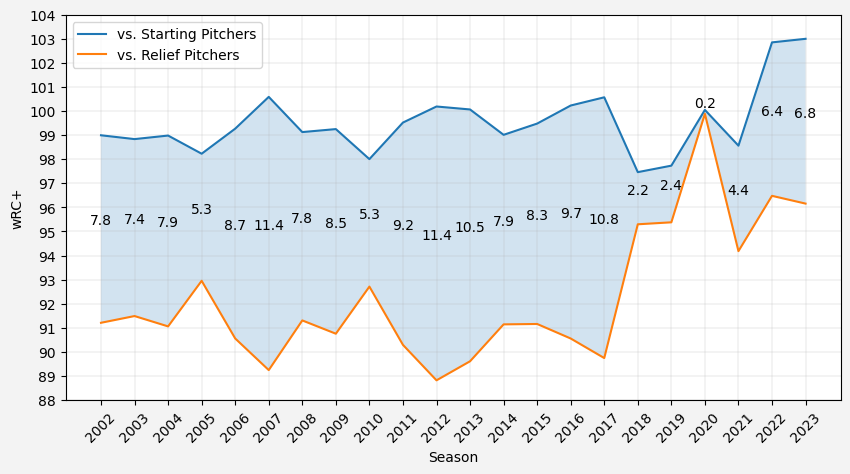

In [8]:
plt.figure(figsize = (10, 5), facecolor = '#f3f3f3')
# plt.scatter(league_seasons_df.Season, league_seasons_df['wRC+'], label = 'Total')
plt.plot(league_seasons_df.Season, league_seasons_df['wRC+ vs. SP'], label = 'vs. Starting Pitchers')
plt.plot(league_seasons_df.Season, league_seasons_df['wRC+ vs. RP'], label = 'vs. Relief Pitchers')
plt.fill_between(league_seasons_df.Season, league_seasons_df['wRC+ vs. SP'], league_seasons_df['wRC+ vs. RP'], alpha = 0.2)
plt.xticks(league_seasons_df.Season, rotation = 45)
plt.yticks(range(88, 105))
plt.xlabel('Season')
plt.ylabel('wRC+')
plt.legend()
plt.grid(linewidth = 0.2)
for _, row in league_seasons_df.iterrows():
    plt.annotate(round(row['wRC+ vs. SP'] - row['wRC+ vs. RP'], 1), (row['Season'], (row['wRC+ vs. SP'] + row['wRC+ vs. RP']) / 2),
                 textcoords = 'offset points', xytext = (0, 3), ha = 'center')
plt.show()

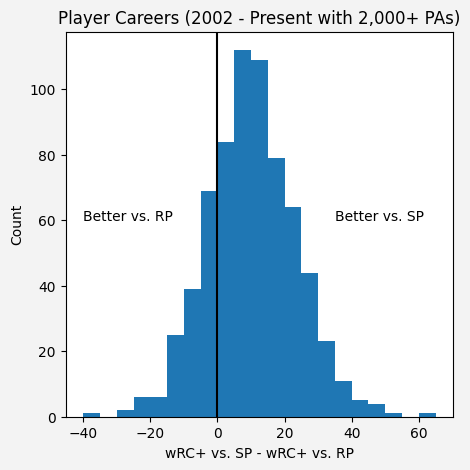

In [9]:
plt.figure(figsize = (5, 5), facecolor = '#f3f3f3')
plt.hist(player_career_df.loc[player_career_df['PA vs. SP'] + player_career_df['PA vs. RP'] >= 2000].apply(lambda row: row['wRC+ vs. SP'] - row['wRC+ vs. RP'], axis = 1), bins = range(-40, 70, 5))
plt.title('Player Careers (2002 - Present with 2,000+ PAs)')
plt.xlabel('wRC+ vs. SP - wRC+ vs. RP')
plt.ylabel('Count')
plt.axvline(x = 0, color = 'black')
plt.annotate('Better vs. RP', xy = (-40, 60))
plt.annotate('Better vs. SP', xy = (35, 60))
plt.show()

It makes sense that the distribution is slightly left-skewed because hitters tend to perform better against starting pitchers than relievers.

## Top Players

I hesitate to label the calculation of *wRC+ vs. SP - wRC+ vs. RP* something like "Prep Factor" because I cannot say with certainty that this is the reason behind the difference

### Qualified Hitters (503+ PAs per Fangraphs)

In [10]:
player_seasons_df \
    .loc[(player_seasons_df.Season == 2023) & (player_seasons_df['PA'] >= 503)] \
    .sort_values('wRC+', ascending = False) \
    .head(20) \
    .set_index(['Season', 'playerId', 'playerName']) \
    .assign(**{'wRC+ vs. SP - wRC+ vs. RP': lambda row: row['wRC+ vs. SP'] - row['wRC+ vs. RP']}) \
    .round() \
    .astype(int) \
    .reset_index()

,Season,playerId,playerName,PA,wRC+,PA vs. SP,wRC+ vs. SP,PA vs. RP,wRC+ vs. RP,wRC+ vs. SP - wRC+ vs. RP
0,2023,19755,Shohei Ohtani,599,179,371,195,228,152,43
1,2023,18401,Ronald Acuña Jr.,735,170,452,182,283,151,31
2,2023,13624,Corey Seager,536,169,321,158,215,185,-27
3,2023,13611,Mookie Betts,693,167,432,150,261,195,-46
4,2023,16578,Yandy Díaz,600,164,383,153,217,184,-31
5,2023,5361,Freddie Freeman,730,162,442,162,288,164,-2
6,2023,14344,Matt Olson,720,160,428,166,292,153,13
7,2023,20123,Juan Soto,708,155,423,143,285,173,-30
8,2023,11579,Bryce Harper,546,142,325,157,221,119,38
9,2023,18345,Kyle Tucker,674,140,408,133,266,151,-18


This further confirms that different players perform very differently versus starting pitchers and relievers.

## Change from Year to Year

<Figure size 640x480 with 0 Axes>

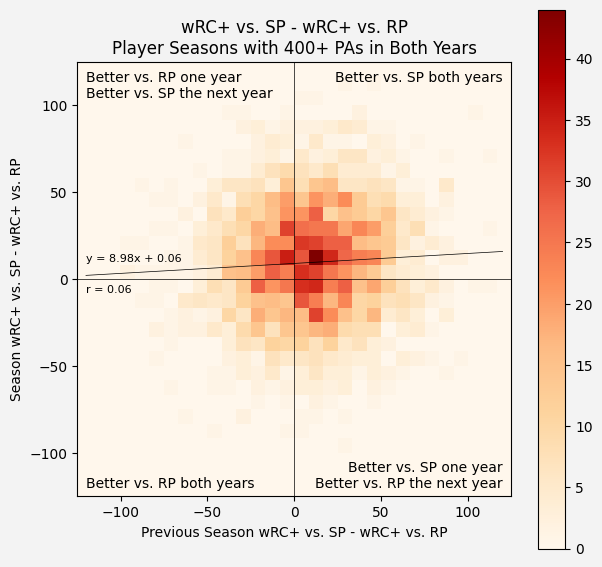

In [11]:
import numpy as np

year_to_year_plot_df = player_seasons_df \
    .assign(**{'Previous Season': lambda row: row['Season'] - 1}) \
    .merge(player_seasons_df.drop(['playerName'], axis = 1), left_on = ['Previous Season', 'playerId'], right_on = ['Season', 'playerId'], suffixes = ('', ' (Prev)')) \
    .drop(['Previous Season', 'Season (Prev)'], axis = 1) \
    .query('PA >= 400 & `PA (Prev)` >= 400') \
    .assign(**{'wRC+ vs. SP - wRC+ vs. RP': lambda row: row['wRC+ vs. SP'] - row['wRC+ vs. RP'],
               'wRC+ vs. SP - wRC+ vs. RP (Prev)': lambda row: row['wRC+ vs. SP (Prev)'] - row['wRC+ vs. RP (Prev)'],
               'Δ wRC+ vs. SP - wRC+ vs. RP': lambda row: row['wRC+ vs. SP - wRC+ vs. RP (Prev)'] - row['wRC+ vs. SP - wRC+ vs. RP']})

heatmap, xedges, yedges = np.histogram2d(year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP (Prev)'], year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP'], bins = 30, range = [[-125, 125], [-125, 125]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

b, a = np.polyfit(year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP (Prev)'], year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP'], deg = 1)
xseq = np.linspace(-120, 120, num = 2400)

plt.clf()
plt.figure(figsize = (7, 7), facecolor = '#f3f3f3')
plt.imshow(heatmap, extent = extent, origin = 'lower', cmap = 'OrRd')
plt.title('wRC+ vs. SP - wRC+ vs. RP\nPlayer Seasons with 400+ PAs in Both Years')
plt.axhline(y = 0, color = 'black', linewidth = 0.5)
plt.axvline(x = 0, color = 'black', linewidth = 0.5)
plt.plot(xseq, a + b * xseq, color = 'black', linewidth = 0.5)
plt.xlabel('Previous Season wRC+ vs. SP - wRC+ vs. RP')
plt.ylabel('Season wRC+ vs. SP - wRC+ vs. RP')
plt.annotate('Better vs. RP one year\nBetter vs. SP the next year', xy = (-120, 120), va = 'top')
plt.annotate('Better vs. SP both years', xy = (120, 120), ha = 'right', va = 'top')
plt.annotate('Better vs. SP one year\nBetter vs. RP the next year', xy = (120, -120), ha = 'right')
plt.annotate('Better vs. RP both years', xy = (-120, -120))
plt.annotate(f'y = {round(a, 2)}x + {round(b, 2)}', xy = (-120, 10), fontsize = 8)
plt.annotate(f'r = {round(np.corrcoef(year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP (Prev)"], year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP"])[0][1], 2)}', xy = (-120, -8), fontsize = 8)
plt.colorbar()
plt.show()

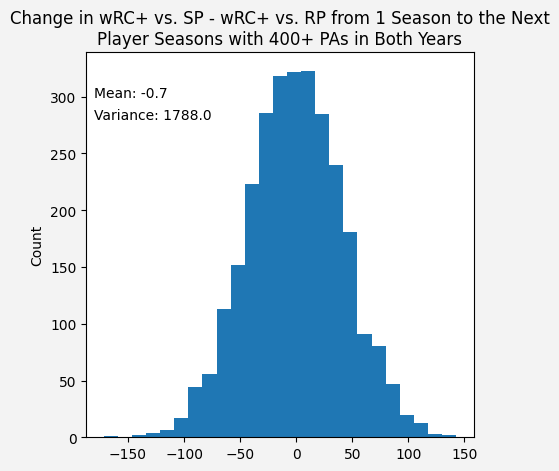

In [12]:
plt.figure(figsize = (5, 5), facecolor = '#f3f3f3')
plt.hist(year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP'] - year_to_year_plot_df['wRC+ vs. SP - wRC+ vs. RP (Prev)'], bins = 25)
plt.title('Change in wRC+ vs. SP - wRC+ vs. RP from 1 Season to the Next\nPlayer Seasons with 400+ PAs in Both Years')
plt.ylabel('Count')
plt.annotate(f'Mean: {round((year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP"] - year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP (Prev)"]).mean(), 1)}', xy = (-180, 300))
plt.annotate(f'Variance: {round((year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP"] - year_to_year_plot_df["wRC+ vs. SP - wRC+ vs. RP (Prev)"]).var(), 1)}', xy = (-180, 280))
plt.show()

In [13]:
year_to_year_plot_df \
    .loc[year_to_year_plot_df.Season == 2023, ['Season', 'playerId', 'playerName', 'wRC+ vs. SP', 'wRC+ vs. RP', 'wRC+ vs. SP - wRC+ vs. RP']] \
    .rename({'wRC+ vs. SP - wRC+ vs. RP': 'Diff'}, axis = 1) \
    .sort_values('Diff') \
    .set_index(['playerId', 'playerName']) \
    .round() \
    .astype(int) \
    .reset_index()

,playerId,playerName,Season,wRC+ vs. SP,wRC+ vs. RP,Diff
0,3473,Anthony Rizzo,2023,74,146,-72
1,19287,Adolis García,2023,98,160,-62
2,15640,Aaron Judge,2023,152,212,-61
3,21479,Nico Hoerner,2023,80,136,-56
4,21636,Jeremy Peña,2023,74,125,-51
...,...,...,...,...,...,...
133,9777,Nolan Arenado,2023,133,68,65
134,15223,Adam Frazier,2023,124,52,72
135,15986,Willy Adames,2023,123,50,73
136,21534,Cal Raleigh,2023,144,68,77


### Most/Least Consistent
group by id -> agg variance of wRC+ vs. SP - wRC+ vs. RP -> line graph lowest/highest

In [14]:
player_seasons_df \
    .loc[player_seasons_df.PA >= 500, ['wRC+ vs. SP', 'wRC+ vs. RP']] \
    .agg([min, max])

/var/folders/7l/yn4n62xj1cl6_7k4vyxmrwnc0000gr/T/ipykernel_95156/3043391900.py:3: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg([min, max])
/var/folders/7l/yn4n62xj1cl6_7k4vyxmrwnc0000gr/T/ipykernel_95156/3043391900.py:3: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg([min, max])


,wRC+ vs. SP,wRC+ vs. RP
min,43.746546,14.361228
max,242.743564,246.209195


In [15]:
player_seasons_df.loc[player_seasons_df.playerId == 411]

,Season,playerName,playerId,PA,wRC+,PA vs. SP,wRC+ vs. SP,PA vs. RP,wRC+ vs. RP
243,2002,Omar Vizquel,411,663,102.021164,468.0,98.836408,195.0,109.667896
1169,2003,Omar Vizquel,411,285,79.211398,196.0,79.798263,89.0,77.930965
2107,2004,Omar Vizquel,411,651,98.933795,435.0,98.091875,216.0,100.633750
3042,2005,Omar Vizquel,411,651,85.668366,474.0,81.900704,177.0,95.642870
3967,2006,Omar Vizquel,411,659,95.093541,469.0,94.588235,190.0,96.344514
4892,2007,Omar Vizquel,411,575,59.807980,387.0,58.597381,188.0,62.289041
5813,2008,Omar Vizquel,411,300,36.864071,194.0,42.381872,106.0,26.711319
6780,2009,Omar Vizquel,411,195,69.389558,117.0,80.222969,78.0,53.491175
7720,2010,Omar Vizquel,411,391,82.894565,271.0,88.437047,120.0,70.246337
8658,2011,Omar Vizquel,411,182,57.721855,124.0,74.544996,58.0,22.009573


In [16]:
from pyperclip import copy

copy(
    player_seasons_df \
        .loc[player_seasons_df.PA >= 400] \
        .assign(**{'Better vs. SP': lambda row: row['wRC+ vs. SP'] > row['wRC+ vs. RP']}) \
        .groupby('playerId') \
        .agg({'playerName': 'first', 'Season': 'count', 'Better vs. SP': 'mean'}) \
        .query('Season >= 5 & (`Better vs. SP` == 0 | `Better vs. SP` == 1)') \
        .sort_values(['Better vs. SP', 'Season'], ascending = False) \
        .rename({'playerName': 'Player', 'Season': 'Seasons w/ 400+ PA (2002 - Present)', 'Better vs. SP': 'Better vs. SP (% of Seasons)'}, axis = 1) \
        .replace({0.0: '0%', 1.0: '100%'}) \
        .to_markdown(index = False)
)

<Figure size 640x480 with 0 Axes>

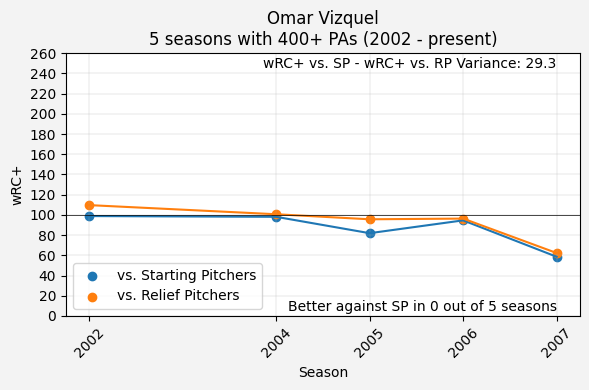

<Figure size 640x480 with 0 Axes>

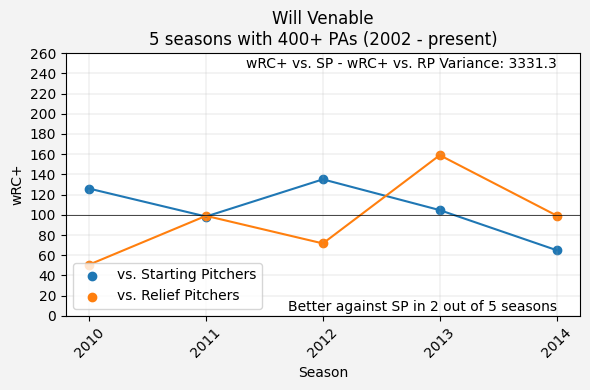

<Figure size 640x480 with 0 Axes>

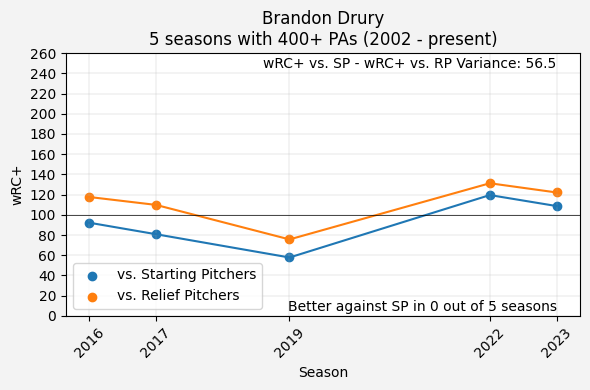

<Figure size 640x480 with 0 Axes>

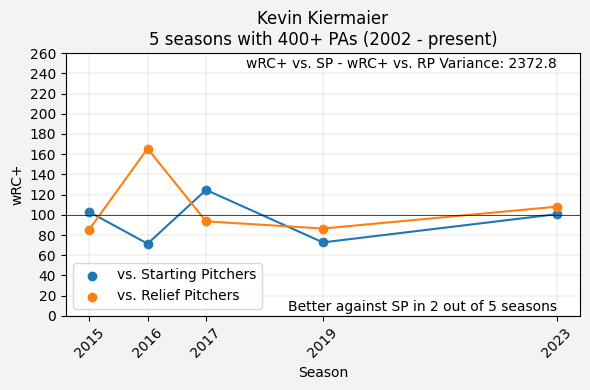

<Figure size 640x480 with 0 Axes>

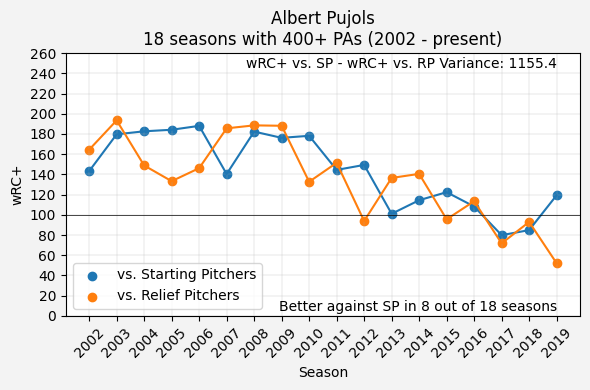

<Figure size 640x480 with 0 Axes>

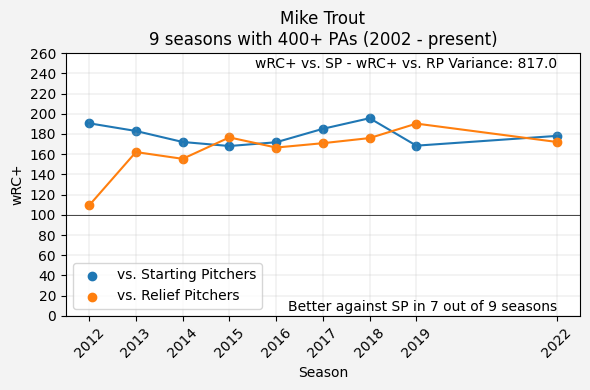

<Figure size 640x480 with 0 Axes>

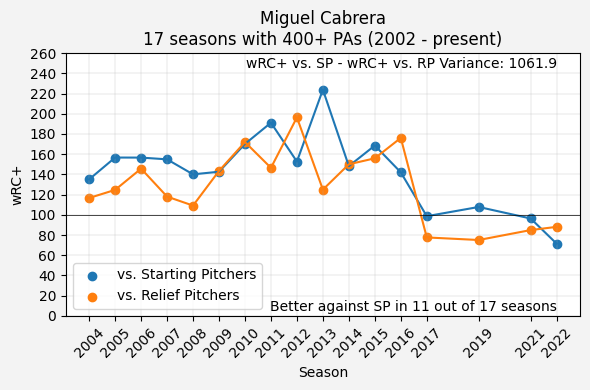

<Figure size 640x480 with 0 Axes>

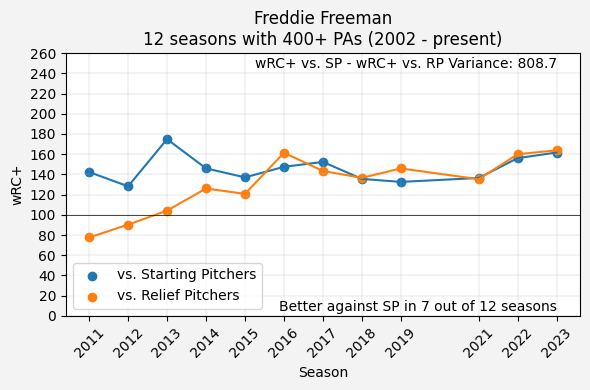

<Figure size 640x480 with 0 Axes>

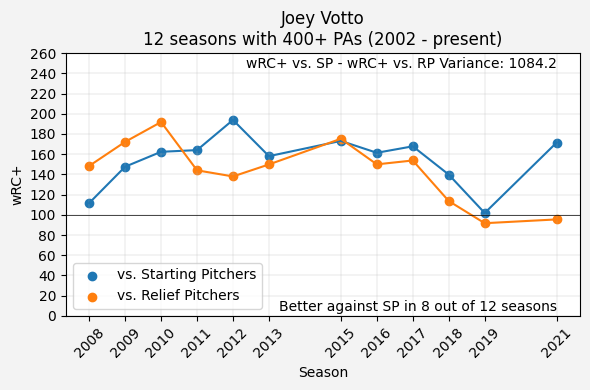

<Figure size 640x480 with 0 Axes>

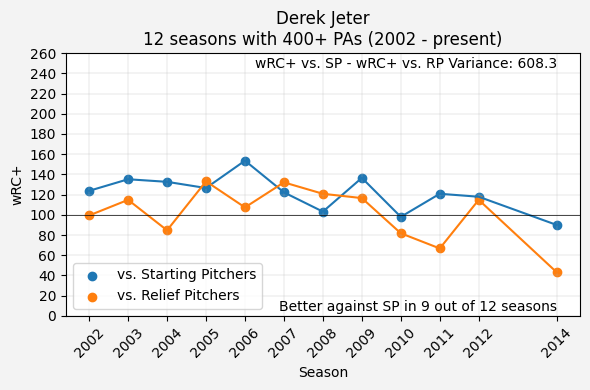

<Figure size 640x480 with 0 Axes>

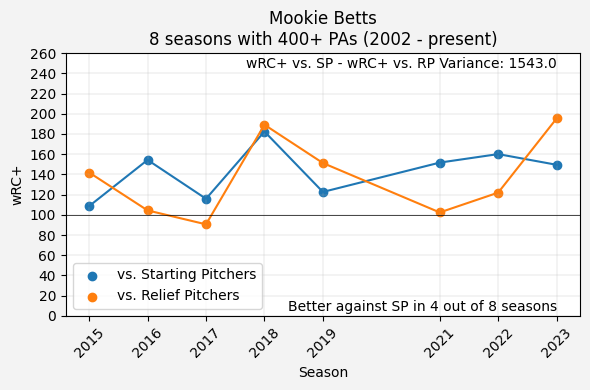

<Figure size 640x480 with 0 Axes>

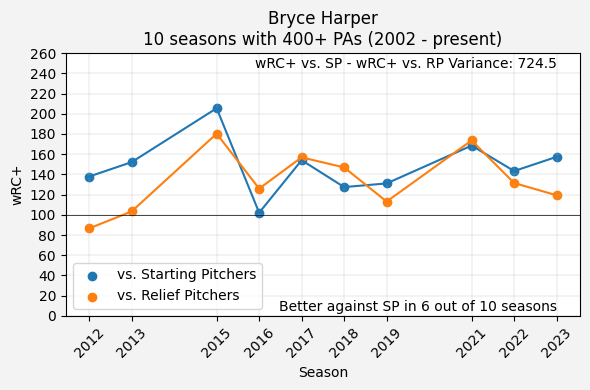

In [17]:
def player_multi_year_graph(ranking = 1, min_pa = 400, min_seasons = 5, played_in_season = 0, player_name = ''):
    player_seasons_df2 = player_seasons_df.copy()
    if player_name in player_seasons_df2['playerName'].unique():
        player_seasons_df2 = player_seasons_df2.merge(player_seasons_df2.loc[player_seasons_df2.playerName == player_name, ['playerId']].drop_duplicates(), on = 'playerId')
    elif played_in_season in player_seasons_df2.Season.unique():
        player_seasons_df2 = player_seasons_df2.merge(player_seasons_df2.loc[player_seasons_df2.Season == played_in_season, ['playerId']].drop_duplicates(), on = 'playerId')

    player_variance_df = player_seasons_df2 \
        .loc[player_seasons_df2.PA >= min_pa] \
        .assign(**{'wRC+ vs. SP - wRC+ vs. RP': lambda row: row['wRC+ vs. SP'] - row['wRC+ vs. RP']}) \
        .groupby('playerId') \
        .agg({'Season': 'count', 'wRC+ vs. SP - wRC+ vs. RP': 'var'}) \
        .query(f'Season >= {min_seasons}') \
        .sort_values('wRC+ vs. SP - wRC+ vs. RP') \
        .rename({'Season': f'seasons w/ {min_pa}+ PA', 'wRC+ vs. SP - wRC+ vs. RP': 'wRC+ vs. SP - wRC+ vs. RP Variance'}, axis = 1) \
        .reset_index()
    
    player_variance_df.index += 1
    if ranking < 0:
        player_variance_df = player_variance_df.iloc[[ranking]]
    else:
        player_variance_df = player_variance_df.loc[[ranking]]
    
    player_variance_df = player_variance_df \
        .merge(player_seasons_df2 \
               .query(f'PA >= {min_pa}') \
               .assign(**{'wRC+ vs. SP - wRC+ vs. RP': lambda row: row['wRC+ vs. SP'] - row['wRC+ vs. RP']}), on = 'playerId')

    plt.clf()
    plt.figure(figsize = (6, 4), facecolor = '#f3f3f3')
    plt.scatter(player_variance_df.Season, player_variance_df['wRC+ vs. SP'], label = 'vs. Starting Pitchers')
    plt.scatter(player_variance_df.Season, player_variance_df['wRC+ vs. RP'], label = 'vs. Relief Pitchers')
    plt.plot(player_variance_df.Season, player_variance_df['wRC+ vs. SP'])
    plt.plot(player_variance_df.Season, player_variance_df['wRC+ vs. RP'])
    plt.xticks(player_variance_df.Season, rotation = 45)
    plt.yticks(range(0, 261, 20))
    plt.axhline(y = 100, color = 'black', linewidth = 0.5)
    plt.title('\n'.join([player_variance_df.iloc[-1]['playerName'],
                         f'{player_variance_df.iloc[0][f"seasons w/ {min_pa}+ PA"]} seasons with {min_pa}+ PAs (2002 - present)']))
    plt.xlabel('Season')
    plt.ylabel('wRC+')
    plt.legend(loc = 'lower left')
    plt.grid(linewidth = 0.2)
    plt.annotate(f'wRC+ vs. SP - wRC+ vs. RP Variance: {round(player_variance_df.iloc[0]["wRC+ vs. SP - wRC+ vs. RP Variance"], 1)}',
                 xy = (player_variance_df.Season.iloc[-1], 245), ha = 'right')
    plt.annotate(f'Better against SP in {len(player_variance_df.loc[player_variance_df["wRC+ vs. SP"] > player_variance_df["wRC+ vs. RP"]].index)} out of {len(player_variance_df.index)} seasons',
                 xy = (player_variance_df.Season.iloc[-1], 5), ha = 'right')
    plt.tight_layout()
    plt.show()

player_multi_year_graph(ranking = 1)
player_multi_year_graph(ranking = -1)

player_multi_year_graph(ranking = 1, played_in_season = 2023)
player_multi_year_graph(ranking = -1, played_in_season = 2023)

player_multi_year_graph(player_name = 'Albert Pujols')
player_multi_year_graph(player_name = 'Mike Trout')
player_multi_year_graph(player_name = 'Miguel Cabrera')
player_multi_year_graph(player_name = 'Freddie Freeman')
player_multi_year_graph(player_name = 'Joey Votto')
player_multi_year_graph(player_name = 'Derek Jeter')
player_multi_year_graph(player_name = 'Mookie Betts')
player_multi_year_graph(player_name = 'Bryce Harper')